<center>
    <img src="https://raw.githubusercontent.com/sentinel-1/GEL_time_traveling_machine/master/images/GEL_rocket_orange_light_alt_(1200x628).png" width="300" alt="Logo of the GEL Time Traveling Machine" />
</center>

# GEL (₾) Time Traveling Machine

*Tip: Select different dates in the inputs given below and/or change amount of money and the result will be updated automatically.*


In [1]:
from IPython.display import display, HTML
display(HTML("""<div id="time-traveling-machine-container"></div>"""))

<br>
<br>

In [2]:
from datetime import datetime, timedelta
nb_st = datetime.utcnow()
print(f"\nNotebook START time: {nb_st} UTC\n")


Notebook START time: 2022-07-16 20:51:40.155719 UTC



In [3]:
%%HTML
<style>
@media (max-width: 540px) {
  .output .output_subarea {
    max-width: 100%;
  }
}
</style>
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('🔎 Show Python Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('⌦ Hide Python Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide();
    $('div.input:contains("%%HTML")').removeClass( "input")
    $('div.input:contains("%%capture")').removeClass("input")
  });
</script>
<form action="javascript:code_toggle()">
  <input type="submit" id="toggleButton" value="🔎 Show Python Code"
         class="btn btn-default btn-lg">
</form>

## Index

- [How it works](#How-it-works)
- [Data](#Data)
  - [Import the data](#Import-the-data)
  - [Descriptive statistics of the data](#Descriptive-statistics-of-the-data)
  - [Visualize the data](#Visualize-the-data)
- [Model](#Model)
  - [Train and Validate Models](#Train-and-Validate-Models)
  - [Train final versions of models](#Train-final-versions-of-models)
  - [Number of Outliers detected by RANSAC](#Number-of-Outliers-detected-by-RANSAC)
  - [Plot resulting models](#Plot-resulting-models)
  - [Select a model](#Select-a-model)
- [Make predictions using the selected model](#Make-predictions-using-the-selected-model)
- [Build the solution](#Build-the-solution)


## How it works

For the past time it uses actual CPI data and for the future time it uses CPI values predicted by the selected model from the models created in this document.

Let's recall concepts of nominal value of money and purchasing power of money:
- Nominal value refers to the number of units of money you have (or simply amount of money).
- Purchasing power refers to how much of goods or services you can buy with the certain number of units of your money.

Nowadays, if you live normal life between the two speciphic dates, then the nominal value of your money during the time is genrally fixed and the purchasing power is generally varying. For example lets say you have 100 GEL banknote:
- The nominal value of the 100 GEL banknote is always 100 GEL, because it represents 100 units of GEL and this value is fixed.
- The purchasing power of the 100 GEL banknote is varying, because 100 units of GEL can buy different amount of goods or services in different points in time, sometimes it is increasing but most of the time is decreasing due to the inflation.

The GEL Time Traveling Machine works in a very similar way as a normal CPI Inflation Calculator would work, a slight difference is that if you time travel between the two speciphic dates using the GEL Time Traveling Machine, then it has a side effect of inverting the above mentioned properties of the nominal value and purchasing power, which allows to see a different perspective of the same event, this is how the time travel works:
- Purchasing power becomes fixed constant relative to the date from where you travel.
- Nominal value of money in your pocket becomes varying depending on where you go in time.

Let's highlight the difference between the GEL Time Traveling Machine (implemented in this notebook) and the GEL CPI Inflation Calculator (not implemented in this notebook):
- Formula used by the standard "GEL CPI Inflation Calculator" would be: $\displaystyle\Large ₾_{t_2}=\frac {₾_{t_1}} {CPI^₾_{t_1}} CPI^₾_{t_2}$
- Formula used by the "GEL Time Traveling Machine" is: $\displaystyle\Large ₾_{t_2}=\frac {₾_{t_1}} {CPI^₾_{t_2}} CPI^₾_{t_1}$

where the ${t_1}$ and ${t_2}$ denote "from" and "to" dates, respectively. Thus, technically the final effect is just to exchange places of the "from" and "to" dates in the GEL Time Traveling Machine relative to the GEL CPI Inflation Calculator, other than that they work alike. Needless to say that even numbers are the same - just in a different order. Well, that is what a time machine usually do, they exchange "from" and "to" times in a blink of an eye.

In conclusion, the GEL Time Traveling Machine shows what would happen in a scenario where the purchasing power is a fixed constant and nominal value of the money in your pocket is varying instead. With only these two changes and all other things being equal, all the final practical effects are equivalent of what could happen in reality, because the varying nominal value in this scenario is compensated by the fixed purchasing power, so the result you get in the GEL Time Traveling Machine above is just a slightly different angle of view into the same actual reality and it can give you some practical insights into inflation and helps you to understand how your pocket is actually affected by the inflation.


## Data

Currently Geostat is using 2010 as the base year for the CPI data.

Data sources:
- Statistical data (in Excel format) of the CPI (Consumer Price Index) and a relevant metadata (in PDF format) are retrieved on Jun 21, 2022 from the website of the National Statistics Office of Georgia (Geostat): [geostat.ge](https://www.geostat.ge/en/)
- Same data is automatically downloaded/updated from the same source by the notebook into the separate file when the `DOWNLOAD_UPDATE` flag is set to `True` in order to use latest available version in this notebook.

In [4]:
BASE_YEAR = 2010

In [5]:
VERBOSE = False
DOWNLOAD_UPDATE = False

In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import wget
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set_theme()


### Import the data

In [7]:
cpi_data_url = ("https://www.geostat.ge/media/"
                f"46069/Consumer-Price-Index-({BASE_YEAR}=100).xlsx")
cpi_data_file = Path.cwd() / "data/geostat/EN/Excel/CPI.xlsx"
backup_file_name = "{}_old{}".format(cpi_data_file.stem, cpi_data_file.suffix)
backup_file = cpi_data_file.with_name(backup_file_name)

if DOWNLOAD_UPDATE:
    if cpi_data_file.exists():
        cpi_data_file.rename(backup_file)
    print("Downloading CPI data from Geostat:")
    cpi_data_file = Path(wget.download(cpi_data_url, out=str(cpi_data_file)))

In [8]:
cpi_df = pd.read_excel(cpi_data_file, skiprows=2)
cpi_df = cpi_df.rename({'Unnamed: 0': 'Year'}, axis=1)

if VERBOSE:
    display(cpi_df.tail())

In [9]:
df = (cpi_df
      .melt(id_vars=['Year'], var_name='Month', value_name='CPI')
      .replace({
          'I': 1,
          'II': 2,
          'III': 3,
          'IV': 4,
          'V': 5,
          'VI': 6,
          'VII': 7,
          'VIII': 8,
          'IX': 9,
          'X': 10,
          'XI': 11,
          'XII': 12
      })
      .set_index(['Year','Month'])
      .sort_index()
      .dropna()
     )

if VERBOSE:
    display(df.tail(14))

In [10]:
start_month, end_month = [
    pd.Timestamp(year=idx[0], month=idx[1], day=1)
    for idx in (df.index.min(), df.index.max())]

print("\nGiven CPI data covers the interval of time "
      f"from {start_month:%B %Y} to {end_month:%B %Y} (inclusive).\n")


Given CPI data covers the interval of time from January 2000 to May 2022 (inclusive).



In [11]:
if df.loc[BASE_YEAR, 'CPI'].mean().item() != 100:
    if backup_file.exists():
        backup_file.rename(backup_file.with_stem(f"CPI_base_{BASE_YEAR}"))
    cpi_data_file.unlink()
    raise Exception("ERROR: CPI of base year != 100. Please verify the data.")
elif backup_file.exists():
    backup_file.unlink()

In [12]:
if VERBOSE:
    display(df.info())

### Descriptive statistics of the data

In [13]:
display(df.describe())

,CPI
count,269.000000
mean,99.125119
std,30.209744
min,51.802700
25%,70.434700
50%,105.700900
75%,117.965000
max,173.184600


### Visualize the data

Before starting to build a linear model, let's visually inspect actual
data points versus fitted line, using a regression plot of the CPI data,
in order to determine if a linear regression model would be an
appropriate choice for the given CPI data or not.

In [14]:
def get_month_number(year: int, month: int) -> int:
    return 12 - start_month.month + 12*(year-start_month.year-1) + month

if VERBOSE:
    print("December 1999 =>", get_month_number(year=1999, month=12))

In [15]:
if VERBOSE:
    for idx, item in df.iterrows():
        print(idx, "=>", get_month_number(*idx))

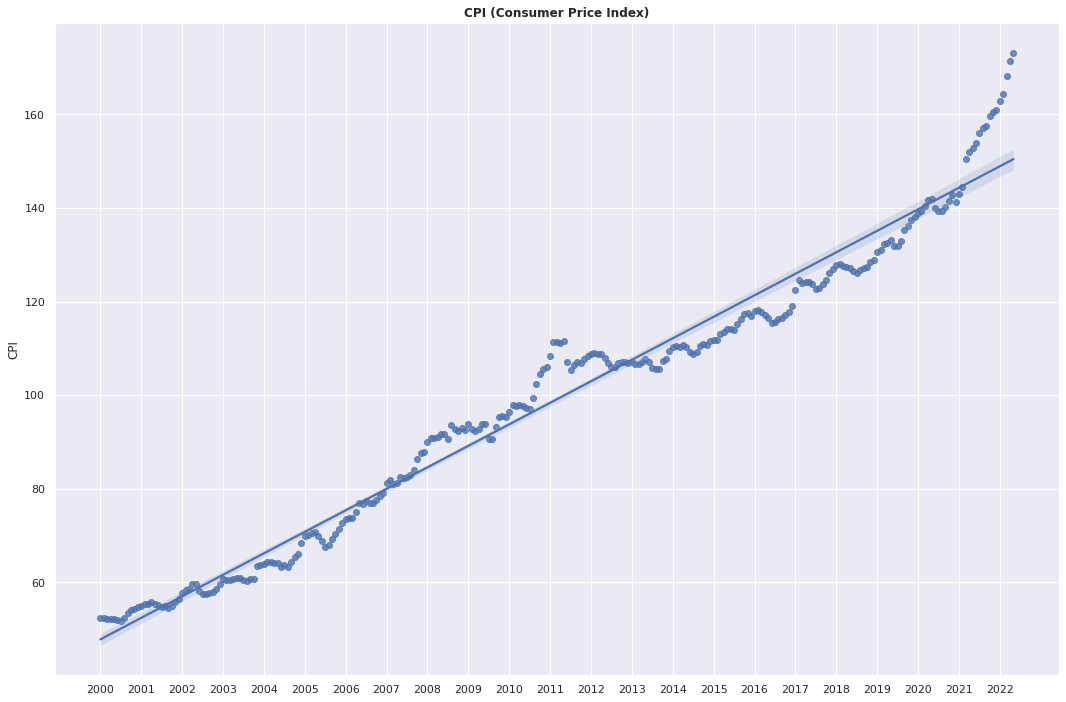

In [16]:
fig = plt.figure(figsize=(18,12))
sns.regplot(y=df['CPI'], x=[get_month_number(*idx) for idx in df.index], ci=99)
plt.title("CPI (Consumer Price Index)", fontweight="bold")
plt.gca().set(
    xticks=[get_month_number(year, 1)
            for year in df.index.get_level_values('Year').unique()],
    xticklabels=df.index.get_level_values('Year').unique().tolist(),
    xlabel='')
plt.show()
plt.close(fig)

## Model

Let's first build and evaluate some models and select one of them later:
- `LinearRegression` is a linear model representing an Ordinary least squares Linear Regression.
- `RANSACRegressor` is a linear model which tries to detect and ignore outliers using the RANSAC (RANdom SAmple Consensus) algorithm.

In [17]:
TEST_SIZE = 0.33
RAND_STATE = 2022  # fix random state for reproducibility

In [18]:
# Linear model
lr = linear_model.LinearRegression()
# Robust linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor(max_trials=100000,
                                      random_state=RAND_STATE)

In [19]:
# Prepare data for training
Y = df['CPI'].to_numpy()
X = np.array([[get_month_number(*idx)] for idx in df.index])
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RAND_STATE)

### Train and Validate Models

Let's evaluate models by measuring select metrics in different contexts.

The following metrics are used for validation:
- Mean absolute error (MAE)
- Mean squared error (MSE)
- Coefficient of determination ($R^2$)

In [20]:
CV=3
cv_results_lr,  cv_results_ransac = [
    cross_validate(model, X, Y, cv=CV,
                   scoring=[
                       "neg_mean_absolute_error",
                       "neg_mean_squared_error",
                       "r2",
                   ],
                   return_train_score=True,
                  )
    for model in (lr, ransac)]
    
print(
        f"""In-sample cross-validated performance using {CV} folds:
        {lr.__class__.__name__}:
        MAE = {-cv_results_lr["train_neg_mean_absolute_error"].mean():.2f}
        MSE = {-cv_results_lr["train_neg_mean_squared_error"].mean():.2f}
        R\u00b2 = {cv_results_lr["train_r2"].mean():.2f}
        {ransac.__class__.__name__}:
        MAE = {-cv_results_ransac["train_neg_mean_absolute_error"].mean():.2f}
        MSE = {-cv_results_ransac["train_neg_mean_squared_error"].mean():.2f}
        R\u00b2 = {cv_results_ransac["train_r2"].mean():.2f}
""")
print(
        f"""Out-of-sample cross-validated performance using {CV} folds:
        {lr.__class__.__name__}:
        MAE = {-cv_results_lr["test_neg_mean_absolute_error"].mean():.2f}
        MSE = {-cv_results_lr["test_neg_mean_squared_error"].mean():.2f}
        R\u00b2 = {cv_results_lr["test_r2"].mean():.2f}
        {ransac.__class__.__name__}:
        MAE = {-cv_results_ransac["test_neg_mean_absolute_error"].mean():.2f}
        MSE = {-cv_results_ransac["test_neg_mean_squared_error"].mean():.2f}
        R\u00b2 = {cv_results_ransac["test_r2"].mean():.2f}
""")

lr.fit(X_train, Y_train)
ransac.fit(X_train, Y_train)

Y_train_pred = lr.predict(X_train)
Y_train_pred_ransac = ransac.predict(X_train)

Y_pred = lr.predict(X_test)
Y_pred_ransac = ransac.predict(X_test)

print(
    f'''\n\nPreliminary models trained on {
      (1-TEST_SIZE)*100
    :.1f}% of data for evaluation:
    "{lr.__class__.__name__}":
    Coefficient (slope) = {lr.coef_[0]:.4f}
    Intercept = {lr.intercept_:.2f}
    "{ransac.__class__.__name__}":
    Coefficient (slope) = {ransac.estimator_.coef_[0]:.4f}
    Intercept = {ransac.estimator_.intercept_:.2f}
''')
print(f"""
    In-sample performance on the {(1-TEST_SIZE)*100:.1f}% train data:
        {lr.__class__.__name__}:
        MAE = {mean_absolute_error(Y_train, Y_train_pred):.2f}
        MSE = {mean_squared_error(Y_train, Y_train_pred):.2f}
        R\u00b2 = {r2_score(Y_train, Y_train_pred):.2f}
        {ransac.__class__.__name__}:
        MAE = {mean_absolute_error(Y_train, Y_train_pred_ransac):.2f}
        MSE = {mean_squared_error(Y_train, Y_train_pred_ransac):.2f}
        R\u00b2 = {r2_score(Y_train, Y_train_pred_ransac):.2f}
""")
print(f"""
    Out-of-sample performance on the {TEST_SIZE*100:.1f}% test data:
        {lr.__class__.__name__}:
        MAE = {mean_absolute_error(Y_test, Y_pred):.2f}
        MSE = {mean_squared_error(Y_test, Y_pred):.2f}
        R\u00b2 = {r2_score(Y_test, Y_pred):.2f}
        {ransac.__class__.__name__}:
        MAE = {mean_absolute_error(Y_test, Y_pred_ransac):.2f}
        MSE = {mean_squared_error(Y_test, Y_pred_ransac):.2f}
        R\u00b2 = {r2_score(Y_test, Y_pred_ransac):.2f}
""")


In-sample cross-validated performance using 3 folds:
        LinearRegression:
        MAE = 3.65
        MSE = 24.42
        R² = 0.95
        RANSACRegressor:
        MAE = 3.55
        MSE = 24.74
        R² = 0.95

Out-of-sample cross-validated performance using 3 folds:
        LinearRegression:
        MAE = 4.89
        MSE = 33.18
        R² = 0.71
        RANSACRegressor:
        MAE = 5.44
        MSE = 38.23
        R² = 0.64



Preliminary models trained on 67.0% of data for evaluation:
    "LinearRegression":
    Coefficient (slope) = 0.3826
    Intercept = 48.08
    "RANSACRegressor":
    Coefficient (slope) = 0.3826
    Intercept = 48.08


    In-sample performance on the 67.0% train data:
        LinearRegression:
        MAE = 3.87
        MSE = 25.52
        R² = 0.97
        RANSACRegressor:
        MAE = 3.87
        MSE = 25.52
        R² = 0.97


    Out-of-sample performance on the 33.0% test data:
        LinearRegression:
        MAE = 3.93
        MSE = 25.14


### Train final versions of models

Let's use all the available data to train final versions of the models.
We can additionally validate in-sample performance here. 

In [21]:
# Train final models using all data:
lr.fit(X, Y)
ransac.fit(X, Y)

print(
    f'''\nFinal models trained on 100% of data:
    "{lr.__class__.__name__}":
    Coefficient (slope) = {lr.coef_[0]:.4f}
    Intercept = {lr.intercept_:.2f}
    "{ransac.__class__.__name__}":
    Coefficient (slope) = {ransac.estimator_.coef_[0]:.4f}
    Intercept = {ransac.estimator_.intercept_:.2f}
''')
Y_pred = lr.predict(X)
Y_pred_ransac = ransac.predict(X)
print(
    f"""
    In-sample performance of the final models:
        {lr.__class__.__name__}:
        MAE = {mean_absolute_error(Y, Y_pred):.2f}
        MSE = {mean_squared_error(Y, Y_pred):.2f}
        R\u00b2 = {r2_score(Y, Y_pred):.2f}
        {ransac.__class__.__name__}:
        MAE = {mean_absolute_error(Y, Y_pred_ransac):.2f}
        MSE = {mean_squared_error(Y, Y_pred_ransac):.2f}
        R\u00b2 = {r2_score(Y, Y_pred_ransac):.2f}
""")


Final models trained on 100% of data:
    "LinearRegression":
    Coefficient (slope) = 0.3829
    Intercept = 47.82
    "RANSACRegressor":
    Coefficient (slope) = 0.3775
    Intercept = 48.30


    In-sample performance of the final models:
        LinearRegression:
        MAE = 3.85
        MSE = 25.34
        R² = 0.97
        RANSACRegressor:
        MAE = 3.75
        MSE = 25.58
        R² = 0.97



### Number of Outliers detected by RANSAC

Let's see how many outliers has `RANSACRegressor` model detected this time.

In [22]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
print(f"RANSAC algorithm has detected {outlier_mask.sum()} outliers "
      "in the CPI data.")

RANSAC algorithm has detected 3 outliers in the CPI data.


### Plot resulting models

Plot the data and final versions of models together to see how well do they fit the data.

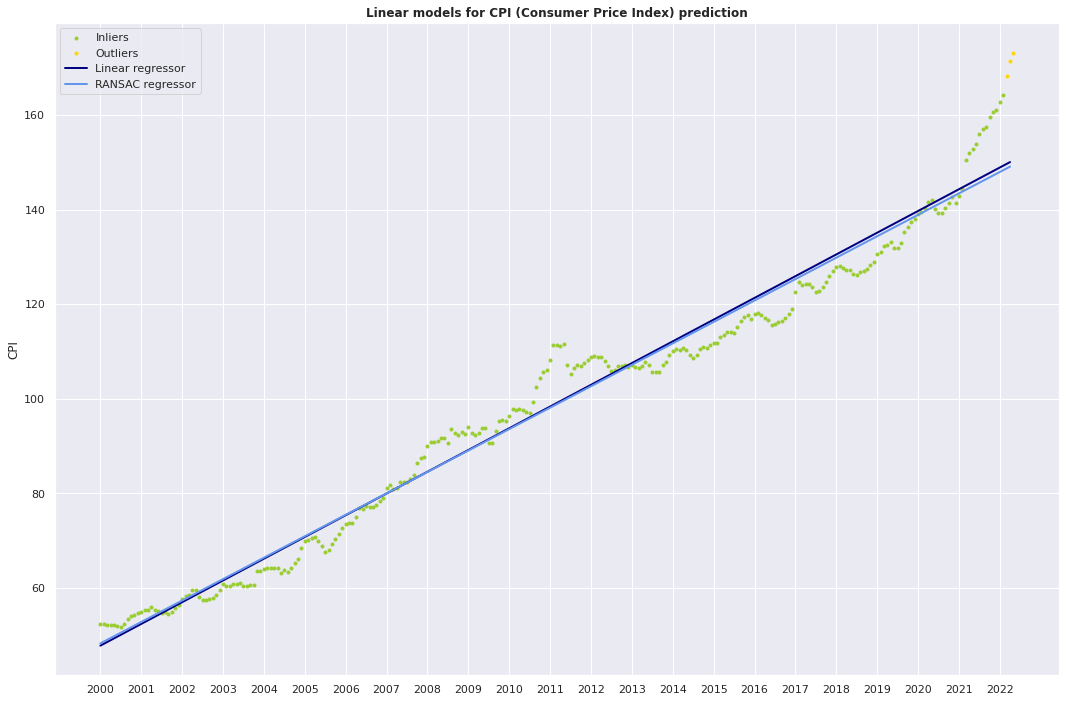

In [23]:
fig = plt.figure(figsize=(18,12))

plt.scatter(X[inlier_mask], Y[inlier_mask], color="yellowgreen", marker=".",
            label="Inliers")
plt.scatter(X[outlier_mask], Y[outlier_mask], color="gold", marker=".",
            label="Outliers")

line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

plt.plot(line_X, line_y, color="navy", linewidth=2,
         label="Linear regressor")
plt.plot(line_X, line_y_ransac, color="cornflowerblue", linewidth=2,
         label="RANSAC regressor")
plt.legend(loc="upper left")
plt.title("Linear models for CPI (Consumer Price Index) prediction",
          fontweight="bold")
plt.gca().set(
    xticks=[get_month_number(year, 1)
            for year in df.index.get_level_values('Year').unique()],
    xticklabels=df.index.get_level_values('Year').unique().tolist(),
    xlabel='',
    ylabel='CPI',
)
plt.show()
plt.close(fig)

### Select a model

Select one of the models we built for usage in the GEL Time Traveling machine.

In [24]:
SELECTED_MODEL = 1

model = [
    lr,  # 0
    ransac,  # 1
][SELECTED_MODEL]
model_color = [
    "navy",
    "cornflowerblue",
][SELECTED_MODEL]

print(f'Selected model is: {model.__class__.__name__}')

Selected model is: RANSACRegressor


## Make predictions using the selected model

In [25]:
pred_years = tuple(range(start_month.year, end_month.year + 11))
df_pred = pd.DataFrame(
    index=pd.MultiIndex.from_tuples([(Y,M)
                                     for Y in pred_years
                                     for M in range(1, 13)
                                    ], names=['Year', 'Month']))
pred_month_num = np.array([get_month_number(*idx) for idx in df_pred.index])
df_pred['CPI_pred'] = model.predict(pred_month_num.reshape(-1, 1))

if VERBOSE:
    display(df_pred)

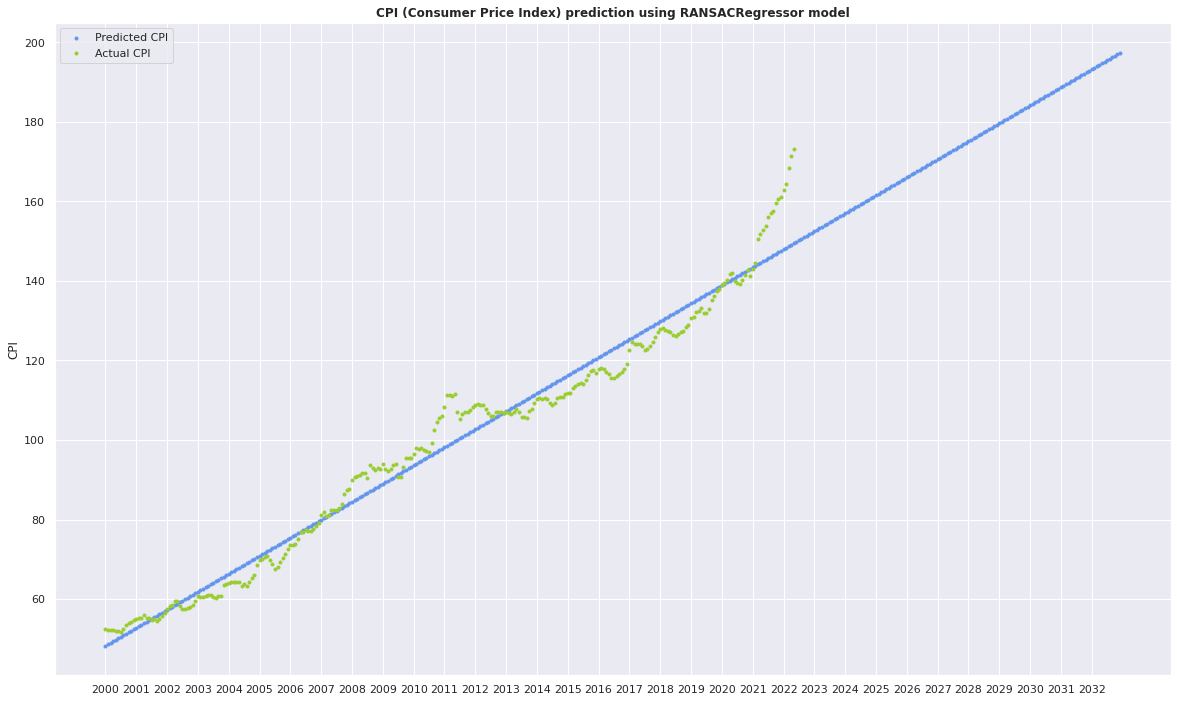

In [26]:
fig = plt.figure(figsize=(20,12))

plt.scatter(pred_month_num, df_pred['CPI_pred'], color=model_color, marker=".",
            label="Predicted CPI")
plt.scatter(X, Y, color="yellowgreen", marker=".",
            label="Actual CPI")

plt.legend(loc="upper left")
plt.title("CPI (Consumer Price Index) prediction using "
          f"{model.__class__.__name__} model", fontweight="bold")
plt.gca().set(
    xticks=[get_month_number(year, 1)
            for year in df_pred.index.get_level_values('Year').unique()],
    xticklabels=df_pred.index.get_level_values('Year').unique().tolist(),
    xlabel='',
    ylabel='CPI',
)
plt.show()
plt.close(fig)

## Build the solution

Building here the solution for the interactive calculations, but instead of displaying it here it is sent back to the beggining of the notebook. [See the result in the beggining of this notebook](#GEL-%28₾%29-Time-Traveling-Machine) - that is where the solugion built below is displayed.

In [27]:
##
# Prepare actual and predicted CPI data for the interactive calculations:
##
CPI_data = {
    y:{}
    for y in df.index.get_level_values('Year').unique()}

CPI_pred_data = {
    y:{}
    for y in df_pred.index.get_level_values('Year').unique()}

for ym in df.index:
    CPI_data[ym[0]][ym[1]] = df.loc[ym,'CPI']
    
for ym in df_pred.index:
    CPI_pred_data[ym[0]][ym[1]] = df_pred.loc[ym,'CPI_pred']

if VERBOSE:
    print("CPI_data: ", json.dumps(CPI_data))
    print("CPI_pred_data: ", json.dumps(CPI_pred_data))

In [28]:
MONTH_NUM_2_NAME = {
    M: pd.Timestamp(year=BASE_YEAR, month=M, day=1).month_name()
    for M in df.loc[BASE_YEAR].index}

MONTH_NUM_2_NAME_KA = {
    M: pd.Timestamp(year=BASE_YEAR, month=M, day=1).month_name(locale='ka_GE.UTF-8')
    for M in df.loc[BASE_YEAR].index}

if VERBOSE:
    print(json.dumps(MONTH_NUM_2_NAME))
    print(json.dumps(MONTH_NUM_2_NAME_KA))

In [29]:
##
# Build the solution for the interactive calculations:
##
def get_raw_html(lang: str = "en"):
    return (f"""
<br>
{"If I will be time traveling" if lang == "en" 
else "თუ დროში ვიმოგზაურებ" }<br>
{"from"  if lang == "en" else "საიდან:"}
<select id="from-month-{lang}" name="travel-start-month">
{''.join([f'''<option value="{i}">{MONTH_NUM_2_NAME[i] if lang == "en" 
                                 else MONTH_NUM_2_NAME_KA[i]}</option>'''
          for i in range(1,13)])}
</select>
{"of"  if lang == "en" else ""} 
<select id="from-year-{lang}" name="travel-start-year">
{' '.join([f'<option value="{Y}">{Y}</option>'
           for Y in df_pred.index.get_level_values('Year').unique()])}
</select>
{"year"  if lang == "en" else "-დან"} <br>
{"to"  if lang == "en" else "სად:"}
<select id="to-month-{lang}" name="travel-end-month">
{''.join([f'''<option value="{i}">{MONTH_NUM_2_NAME[i] if lang == "en"
                                 else MONTH_NUM_2_NAME_KA[i]}</option>'''
          for i in range(1,13)])}
</select>
{"of"  if lang == "en" else ""} 
<select id="to-year-{lang}" name="travel-end-year">
{' '.join([f'<option value="{Y}" '
           f'{"selected" if Y == BASE_YEAR else ""}>{Y}</option>'
           for Y in df_pred.index.get_level_values('Year').unique()])}
</select>
{"year"  if lang == "en" else "-ში"}<br>
{"and I got initially"  if lang == "en" else "და დასაწყისისთვის მაქვს"}
<input type="number" id="money-before-{lang}" name="travel-start-money"
       min="1" value="100">
GEL {"in my pocket,"  if lang == "en" else "ჩემს ჯიბეში,"}<br>
{"then I will have"  if lang == "en" else "მაშინ მე მექნება"}
<u><span id="result-certitude-{lang}"></span>
<strong id="money-after-{lang}">#.##</strong> GEL</u>
{"in the pocket when I reach the destination."  if lang == "en"
else "ჯიბეში როცა ჩავალ დანიშნულების ადგილას."}
<br><br>
<div>{"Explanation of the above result:"  if lang == "en" 
else "ზემოთ მიღებული შედეგის განმარტება:"}</div>
<div id="result-explanation-title-{lang}"
     style="font-size: larger; margin-top:3px;margin-bottom:3px;"></div>
<div id="result-explanation-body-{lang}" 
     style="max-width:32em; font-size:small;"></div>

""")


def get_raw_js(lang="en"):
    return (f"""
//<script type="application/javascript">
var CPI_data = {json.dumps(CPI_data)};
var CPI_pred_data = {json.dumps(CPI_pred_data)};
var MONTH_NUM_2_NAME = {json.dumps(MONTH_NUM_2_NAME) if lang == "en"
                        else json.dumps(MONTH_NUM_2_NAME_KA)};
var MODEL_NAME = "{model.__class__.__name__}";
""""""
((fn)=>{
  if (document.readyState != 'loading'){
    fn();
} else {
    document.addEventListener('DOMContentLoaded', fn);
}
})(()=>{
"""f"""
//console.log("Time Traveling Machine is READY!!!");
let inFromMonth = document.getElementById("from-month-{lang}");
let inFromYear = document.getElementById("from-year-{lang}");
let inToMonth = document.getElementById("to-month-{lang}");
let inToYear = document.getElementById("to-year-{lang}");
let inMoneyBefore = document.getElementById("money-before-{lang}");

let outResultCertitude = document.getElementById("result-certitude-{lang}");
let outMoneyAfter = document.getElementById("money-after-{lang}");
let outExplanationTitle = document.getElementById(
    "result-explanation-title-{lang}"
);
let outExplanationBody = document.getElementById(
    "result-explanation-body-{lang}"
);
""""""

let isRecordInData = (year, month, data) => {
    return data.hasOwnProperty(year) && data[year].hasOwnProperty(month);
}
let getCPI = (year, month, data) => data[year][month];

let doTimeTravel = (startYear, startMonth, endYear, endMonth, moneyBefore) => {
    moneyBefore = parseFloat(moneyBefore);
    let isDataAvailable = isRecordInData(startYear, startMonth, CPI_data) &&
                          isRecordInData(endYear, endMonth, CPI_data);
                          
    if (isDataAvailable) {
"""f"""
        outResultCertitude.innerText = "{"exactly"  if lang == "en"
else "ზუსტად"}";
        var data = CPI_data;
        var toBeWorthText = "{"is worth"  if lang == "en"
else "არის ღირებული როგორც"}";
    }} else {{
        outResultCertitude.innerText = "{"approximately"  if lang == "en"
else "მიახლოებით"}";
        var data = CPI_pred_data;
        var toBeWorthText = "{"is estimated to be worth"  if lang == "en"
else "სავარაუდოა იყოს ღირებული როგორც"}";
    }}
    let startCPI = getCPI(startYear, startMonth, data);
    let endCPI = getCPI(endYear, endMonth, data);
    let moneyAfter = startCPI * (moneyBefore/endCPI);
    moneyAfter = moneyAfter.toFixed(2);
    moneyBefore = moneyBefore.toFixed(2);
    outMoneyAfter.innerText = moneyAfter;
    
    outExplanationTitle.innerText = [
            moneyBefore + "₾ {"in"  if lang == "en" else ""}", 
            MONTH_NUM_2_NAME[endMonth],
            endYear + "{""  if lang == "en" else "-ში"}",
            toBeWorthText,
            moneyAfter + "₾ {"in"  if lang == "en" else ""}",
            MONTH_NUM_2_NAME[startMonth],
            startYear + "{""  if lang == "en" else "-ში"}",
        ].join(" ");

    if (isDataAvailable) {{
        outExplanationBody.innerHTML = (
        " {"Selected dates"  if lang == "en" else "შერჩეული თარიღებიდან"} ("
        + MONTH_NUM_2_NAME[startMonth]
        + " "
        + startYear
        + " {"and"  if lang == "en" else "და"} "
        + MONTH_NUM_2_NAME[endMonth]
        + " " 
        + endYear
        + ")"
        + " {"are both present in the actual CPI data from Geostat,"  
if lang == "en" else "ორივე მოცემულია საქსტატის სფი მონაცემებში,"}"
        + " {"thus the result is directly calculated from the data."  
if lang == "en" else
"შესაბამისად ეს შედეგი პირდაპირ გამოთვლილია მონაცემებზე დაყრდნობით."}"
        );
    }} else {{
        outExplanationBody.innerHTML = (
        " {"One (or both) of the selected dates"
if lang == "en" else "შერჩეული თარიღებიდან"} ("
        + MONTH_NUM_2_NAME[startMonth]
        + " "
        + startYear
        + " {"and"  if lang == "en" else "და"} "
        + MONTH_NUM_2_NAME[endMonth]
        + " " 
        + endYear
        + ")"
        + " {"is not present in the CPI data from Geostat,"  
if lang == "en" else
" ერთ-ერთი (ან ორივე) არ არის მოცემული საქსტატის სფი მონაცემებში,"}"
        + " {"thus the result is obtained using the "  
if lang == "en" else
"შესაბამისად ეს შედეგი მიღებულია "}"
        + MODEL_NAME
        + " {"model."  if lang == "en" else "მოდელის გამოყენებით."}"
        );
""""""
    }
};

let inputHandler = (e) => {
    doTimeTravel(inFromYear.value, inFromMonth.value,
                  inToYear.value, inToMonth.value, inMoneyBefore.value);
                  
};

for (let el of [inFromYear, inFromMonth, inToYear, inToMonth, inMoneyBefore]){
    el.addEventListener('input', inputHandler);
}


let event = document.createEvent('HTMLEvents');
event.initEvent('input', true, false);
inMoneyBefore.dispatchEvent(event);

});
//</script>
""")


with open("GEL_TTM_ka.html", "w") as f:
    f.write(get_raw_html(lang="ka"))
    
with open("GEL_TTM_ka.js", "w") as f:
    f.write(get_raw_js(lang="ka"))


raw_html = get_raw_html()
raw_js = get_raw_js()

if VERBOSE:
    print(raw_html)
    print(raw_js)

In [30]:
##
# Send it back to the beggining of the notebook instead of showing here:
##
display(HTML("""<script type="application/javascript">
((fn)=>{
  if (document.readyState != 'loading'){
    fn();
} else {
    document.addEventListener('DOMContentLoaded', fn);
}
})(()=>{
let ttm_container = document.getElementById("time-traveling-machine-container");
"""f"""
ttm_container.insertAdjacentHTML("afterbegin", `{raw_html}`);
let script = document.createElement('script');
script.type="application/javascript";
script.textContent = `"""
+ raw_js.replace("</script>", "<\/script>") 
+ """`;
ttm_container.parentNode.appendChild(script);
""""""
});
</script>
"""))

In [31]:
print(f"\n ** Total Elapsed time: {datetime.utcnow() - nb_st} ** \n")
print(f"Notebook END time: {datetime.utcnow()} UTC\n")


 ** Total Elapsed time: 0:00:02.077411 ** 

Notebook END time: 2022-07-16 20:51:42.233236 UTC



In [32]:
%%capture
%mkdir OGP_classic

In [33]:
%%capture
%%file "OGP_classic/conf.json"
{
  "base_template": "classic",
  "preprocessors": {
    "500-metadata": {
      "type": "nbconvert.preprocessors.ClearMetadataPreprocessor",
      "enabled": true,
      "clear_notebook_metadata": true,
      "clear_cell_metadata": true
    },
    "900-files": {
      "type": "nbconvert.preprocessors.ExtractOutputPreprocessor",
      "enabled": true
    }
  }
}

In [34]:
%%capture
%%file "OGP_classic/index.html.j2"
{%- extends 'classic/index.html.j2' -%}
{%- block html_head -%}

{#  OGP attributes for shareability #}
<meta property="og:url"          content="https://sentinel-1.github.io/GEL_time_traveling_machine/" />
<meta property="og:type"         content="article" />
<meta property="og:title"        content="GEL (₾) Time Traveling Machine" />
<meta property="og:description"  content="How much does inflation affect your pocket in Georgia?" />
<meta property="og:image"        content="https://raw.githubusercontent.com/sentinel-1/GEL_time_traveling_machine/master/images/GEL_rocket_orange_light_alt_(1200x628).png" />
<meta property="og:image:alt"    content="Logo of the GEL Time Traveling Machine" />
<meta property="og:image:type"   content="image/png" />
<meta property="og:image:width"  content="1200" />
<meta property="og:image:height" content="628" />
    
<meta property="article:published_time" content="2022-06-26T23:07:36+00:00" />
<meta property="article:modified_time"  content="{{ resources.iso8610_datetime_now }}" />
<meta property="article:publisher"      content="https://sentinel-1.github.io" />
<meta property="article:author"         content="https://github.com/sentinel-1" />
<meta property="article:section"        content="datascience" />
<meta property="article:tag"            content="datascience" />
<meta property="article:tag"            content="Python" />
<meta property="article:tag"            content="data" />
<meta property="article:tag"            content="analytics" />
<meta property="article:tag"            content="datavisualization" />
<meta property="article:tag"            content="bigdataunit" />
<meta property="article:tag"            content="visualization" />
<meta property="article:tag"            content="inflation" />
<meta property="article:tag"            content="GEL" />
<meta property="article:tag"            content="Lari" />
<meta property="article:tag"            content="CPI" />
<meta property="article:tag"            content="timetravelingmachine" />
    
    
{{ super() }}

{%- endblock html_head -%}
    
    
{% block body_header %}
<body>
    
<div class="container">
  <nav class="navbar navbar-default">
    <div class="container-fluid">
      <ul class="nav nav-pills  navbar-left">
        <li role="presentation">
          <a href="/">
            <svg xmlns="http://www.w3.org/2000/svg"
                 viewBox="0 0 576 512" width="1em">
              <path 
                fill="#999999"
d="M 288,0 574,288 511,288 511,511 352,511 352,352 223,352 223,511 62,511 64,288 0,288 Z"
              />
            </svg> Home
          </a>
        </li>
      </ul>
      <ul class="nav nav-pills  navbar-right">
        <li role="presentation" class="active">
          <a href="/GEL_time_traveling_machine/">🇬🇧 English </a>
        </li>
        <li role="presentation">
          <a href="/GEL_time_traveling_machine/ka/">🇬🇪 ქართული</a>
        </li>
      </ul>
    </div>
  </nav>
</div>



  <div tabindex="-1" id="notebook" class="border-box-sizing">
    <div class="container" id="notebook-container">    
{% endblock body_header %}

{% block body_footer %}
    </div>
  </div>
  <footer>
    <div class="container"
         style="display:flex; flex-direction: row; justify-content: center; align-items: center;">
      <p style="margin: 3.7em auto;"> © 2022
        <a href="https://github.com/sentinel-1" target="_blank">Sentinel-1</a>
      </p>
      <!-- TOP.GE ASYNC COUNTER CODE -->
      <div id="top-ge-counter-container" data-site-id="116052"
           style="margin-right: 3.7em;float: right;"></div>
      <script async src="//counter.top.ge/counter.js"></script>
      <!-- / END OF TOP.GE COUNTER CODE -->
      <!-- ANALYTICS.LAGOGAL.COM -->
      <div id="analytics-lagogal-com-access" data-site-id="20221"
           style="margin: 0;padding: 0;"></div>
      <script async src="//analytics.lagogal.com/access.js"></script>
      <!-- / END OF ANALYTICS.LAGOGAL.COM -->
     </div>
  </footer>
</body>
{% endblock body_footer %}

*This notebook is originally published under the Apache License (Version 2.0) at the following GitHub repository: [sentinel-1/GEL_time_traveling_machine](https://github.com/sentinel-1/GEL_time_traveling_machine)*

For the issues, feedback or suggestions regarding the original notebook (if any) feel free to open an issue at the corresponding [Issues page of the repository](https://github.com/sentinel-1/GEL_time_traveling_machine/issues)